<a href="https://colab.research.google.com/github/AlkaidCheng/example/blob/master/MLHEP_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [21]:
!wget https://gitlab.cern.ch/clcheng/mlhep-googlesummerofcode/raw/master/Prerequisite/MachineLearning/QIS_EXAM_200Events.npz

--2020-03-09 13:23:55--  https://gitlab.cern.ch/clcheng/mlhep-googlesummerofcode/raw/master/Prerequisite/MachineLearning/QIS_EXAM_200Events.npz
Resolving gitlab.cern.ch (gitlab.cern.ch)... 188.184.30.115, 188.184.31.136, 188.184.28.144, ...
Connecting to gitlab.cern.ch (gitlab.cern.ch)|188.184.30.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9140 (8.9K) [application/zip]
Saving to: ‘QIS_EXAM_200Events.npz.1’

QIS_EXAM_200Events. 100%[===================>]   8.93K  --.-KB/s    in 0s      

2020-03-09 13:23:56 (81.9 MB/s) - ‘QIS_EXAM_200Events.npz.1’ saved [9140/9140]



In [0]:
! pip install lightgbm --no-deps  --upgrade --force-reinstall --install-option=--gpu

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 686kB 2.8MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
    Running setup.py install for lightgbm ... done


In [0]:
def install_module(name):
  if name == 'lightgbm':
    try:
      import lightgbm
    except ModuleNotFoundError:
      ! pip install lightgbm --no-deps  --upgrade --force-reinstall --install-option=--gpu
      import lightgbm
  elif name == 'catboost':
    try:
      import catboost
    except ModuleNotFoundError:
      ! pip install catboost
  elif name == 'xgboost':
    try:
      import xgboost
    except ModuleNotFoundError:
      ! pip install xgboost
  elif name == 'skorch':
    try:
      import skorch
    except ModuleNotFoundError:
      ! pip install skorch

In [0]:
def shuffle_zippedarrays(arrays):
  shape = arrays[0].shape
  assert all(shape == arrays[0].shape for arr in arrays)
  index = np.random.permutation(shape[0])
  return [arr[index] for arr in arrays]

def shuffle_data(input, label):
  output = shuffle_zippedarrays([input,label])
  return output[0], output[1]

def load_data(arrays, shuffle = True):
  data = {}
  for key in arrays:
    input, label = np.array([]), np.array([])
    for klabel in arrays[key].item():
      _input = arrays[key].item()[klabel]
      _label = np.full((_input.shape[0],),int(klabel))
      input = np.concatenate((input,_input),axis=0) if input.size else _input
      label = np.concatenate((label,_label),axis=0) if label.size else _label
    if shuffle:
      input, label = shuffle_data(input, label)
    data[key] = {'input': input, 'label': label}
  return data
def load_train_test_input_labels(arrays, shuffle = True):
  data = load_data(arrays, shuffle)
  return data['training_input']['input'], data['test_input']['input'], data['training_input']['label'], data['test_input']['label']

In [0]:
data = np.load('QIS_EXAM_200Events.npz',allow_pickle=True)
train_input, test_input, train_label, test_label = load_train_test_input_labels(data)

In [0]:
install_module('skorch')
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
torch.manual_seed(0)
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

In [0]:

def get_model(model, gpu = True):
  if model == 'RandomForest':
    from sklearn.ensemble import RandomForestClassifier
    param = {'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 280}
    #param = {}
    return RandomForestClassifier(**param)
  elif model == 'DecisionTree':
    from sklearn.tree import DecisionTreeClassifier
    #param =  {'criterion': 'entropy', 'max_depth': 29, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4}
    param = {}
    return DecisionTreeClassifier(**param)
  elif model == 'xgboost':
    install_module('xgboost')
    import xgboost
    if gpu:
      param = {'booster': 'gbtree', 'colsample_bytree': 0.9726979433987133, 'eta': 0.013692988629520534, 'eval_metric': 'logloss', 'gamma': 3.990499197892894, 'grow_policy': 'lossguide', 'max_depth': 21, 'min_child_weight': 8.0, 'num_threads': 4, 'objective': 'binary:logistic', 'subsample': 0.7025619513749428, 'tree_method': 'gpu_hist', 'verbosity': 0}
      #param = {}
      return xgboost.XGBClassifier(**param)
      #return xgboost.XGBClassifier(tree_method="gpu_hist")
    else:
      return xgboost.XGBClassifier(tree_method="hist", thread_count=-1)
  elif model == 'lightgbm':
    install_module('lightgbm')
    import lightgbm
    param = {'boosting_type': 'gbdt', 'subsample': 0.8069159416588685, 'colsample_bytree': 0.8186783735937218, 'learning_rate': 0.04669483279255087, 'metric': 'binary_logloss', 'num_leaves': 714, 'objective': 'binary', 'reg_alpha': 0.6570397599979627, 'reg_lambda': 0.03784950639114426, 'verbose': 0}
    #param = {"device_type" :"gpu"}
    if gpu:
      return lightgbm.LGBMClassifier(**param)
    else:
      return lightgbm.LGBMClassifier(num_threads=-1, **param)
  elif model == 'catboost':
    install_module('catboost')
    #param =  {'depth': 6, 'eval_metric': 'AUC', 'iterations': 100, 'l2_leaf_reg': 4.606475900207236, 'learning_rate': 0.838593997258924, 'loss_function': 'Logloss'}
    param ={'depth': 1, 'eval_metric': 'AUC', 'iterations': 100, 'l2_leaf_reg': 3.1198327753070645, 'learning_rate': 0.45955238467520804, 'loss_function': 'Logloss'}
    #param = {'depth': 10.0, 'eval_metric': 'AUC', 'iterations': 100, 'l2_leaf_reg': 6.133550677000716, 'learning_rate': 0.9007733351029805, 'loss_function': 'Logloss'}
    #param = {'depth': 14.0, 'eval_metric': 'Logloss', 'iterations': 100, 'l2_leaf_reg': 8.156909606280522, 'learning_rate': 1.2545243623307063e-06, 'loss_function': 'Logloss'}
    #param = {}
    import catboost
    if gpu:
      return catboost.CatBoostClassifier( **param)
    else:
      return catboost.CatBoostClassifier(thread_count=-1, **param)
  elif model == 'svm':
    from sklearn.svm import SVC
    #param =  {'C': 24.678539630231498, 'gamma': 'auto', 'kernel': 'linear'}
    param = {}
    return SVC(probability = True, **param)
  elif model == 'nn':
    import torch
    from torch import nn
    import torch.nn.functional as F
    from skorch import NeuralNetClassifier
    torch.manual_seed(0);
    net = NeuralNetClassifier(
        ClassifierModule,
        max_epochs=20,
        lr=0.1,
        device='cuda',  # comment this to train with CPU
        optimizer__momentum=0.9,

        verbose=0
    )

In [0]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0:	total: 411us	remaining: 40.7ms
1:	total: 853us	remaining: 41.8ms
2:	total: 1.52ms	remaining: 49ms
3:	total: 2.54ms	remaining: 61ms
4:	total: 2.8ms	remaining: 53.2ms
5:	total: 7.58ms	remaining: 119ms
6:	total: 7.87ms	remaining: 105ms
7:	total: 8.11ms	remaining: 93.3ms
8:	total: 8.32ms	remaining: 84.1ms
9:	total: 8.52ms	remaining: 76.7ms
10:	total: 8.72ms	remaining: 70.6ms
11:	total: 8.97ms	remaining: 65.8ms
12:	total: 9.16ms	remaining: 61.3ms
13:	total: 9.44ms	remaining: 58ms
14:	total: 9.65ms	remaining: 54.7ms
15:	total: 9.86ms	remaining: 51.7ms
16:	total: 10.1ms	remaining: 49.2ms
17:	total: 10.3ms	remaining: 47ms
18:	total: 10.5ms	remaining: 44.8ms
19:	total: 10.7ms	remaining: 42.7ms
20:	total: 11ms	remaining: 41.2ms
21:	total: 11.1ms	remaining: 39.5ms
22:	total: 11.3ms	remaining: 38ms
23:	total: 11.6ms	remaining: 36.6ms
24:	total: 11.7ms	remaining: 35.2ms
25:	total: 11.9ms	remaining: 34ms
26:	total: 12.1ms	remaining: 32.8ms
27:	total: 12.3ms	remaining: 31.7ms
28:	total: 12.5ms	rem

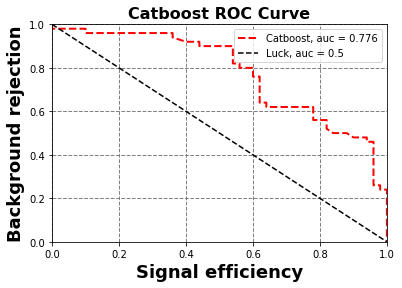

In [64]:
'''
aucs = []
for _ in range(1):
  model = get_model('x')
  model.fit(train_input,train_label)
  fpr,tpr,_ = roc_curve(test_label,model.predict_proba(test_input)[:,1])	
  auc_score = auc(fpr, tpr)
  aucs.append(auc_score)
print(np.average(aucs))
print(np.std(aucs))
'''
model = get_model('catboost')
model.fit(train_input,train_label)
fpr,tpr,_ = roc_curve(test_label,model.predict_proba(test_input)[:,1])	
auc_score = auc(fpr, tpr)
plt.xlabel("Signal efficiency", fontsize = 18, fontweight = 'bold')
plt.ylabel("Background rejection", fontsize = 18, fontweight = 'bold')
plt.title("Catboost ROC Curve", fontsize = 16, fontweight = 'bold')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.grid(color='gray',linestyle='--',linewidth=1)
plt.plot(tpr,1-fpr,'r--',label='Catboost, auc = %0.3f'%auc_score,linewidth = 2)
plt.plot([0,1],[1,0],linestyle='--',color='black',label='Luck, auc = 0.5')
plt.legend(loc='best')
plt.savefig('catboost_roc.eps')

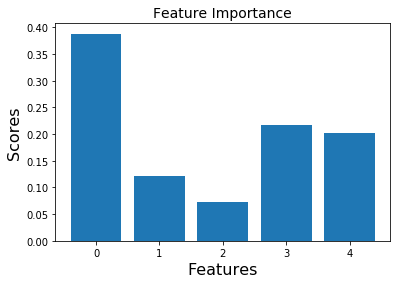

In [0]:
from xgboost import plot_importance
plt.clf()
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.ylabel('Scores', fontsize=16)
plt.xlabel('Features', fontsize=16)
plt.title('Feature Importance', fontsize=14)
plt.savefig('feature_importance.eps')